1. Загрузка данных

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import vstack

df = pd.read_csv("frontend_dataset.csv")

X = df["title"]
y = df["relevant"]

vectorizer = TfidfVectorizer(stop_words="english")
X_vect = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

2. Инициализация модели

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

history = {"n_samples": [], "accuracy": [], "f1_score": []}

initial_train_size = 0.1
X_train_init, X_test, y_train_init, y_test = train_test_split(X_vect, y, test_size=1-initial_train_size, random_state=42)

model.fit(X_train_init, y_train_init)

y_pred = model.predict(X_test)
initial_accuracy = accuracy_score(y_test, y_pred)
initial_f1 = f1_score(y_test, y_pred, average="weighted")

history["n_samples"].append(X_train_init.shape[0])
history["accuracy"].append(initial_accuracy)
history["f1_score"].append(initial_f1)

print(f"Initial Accuracy: {initial_accuracy:.4f}, Initial F1-score: {initial_f1:.4f}")

Initial Accuracy: 0.7107, Initial F1-score: 0.6178


# 3. Цикл активного обучения

In [19]:
N_ITERATIONS = 20

for i in range(N_ITERATIONS):
    print(f"\nIteration {i + 1}/{N_ITERATIONS}")

    model.fit(X_train_init, y_train_init)

    y_pred_test = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average="weighted")
    print(f"  Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

    history["n_samples"].append(X_train_init.shape[0])
    history["accuracy"].append(accuracy)
    history["f1_score"].append(f1)

    probas_unlabeled = model.predict_proba(X_train)
    uncertainty_scores = 1 - np.max(probas_unlabeled, axis=1)

    num_to_query = 10
    uncertain_samples_idx = np.argsort(uncertainty_scores)[-num_to_query:]

    queried_data = df.iloc[uncertain_samples_idx]
    y_queried = queried_data["relevant"].values
    X_queried = vectorizer.transform(queried_data["title"])

    X_train_init = vstack([X_train_init, X_queried])
    y_train_init = np.concatenate([y_train_init, y_queried])

    print(f"  Total samples in training set: {X_train_init.shape[0]}")


Iteration 1/20
  Accuracy: 0.7107, F1-score: 0.6178
  Total samples in training set: 41

Iteration 2/20
  Accuracy: 0.7857, F1-score: 0.7490
  Total samples in training set: 51

Iteration 3/20
  Accuracy: 0.8179, F1-score: 0.7926
  Total samples in training set: 61

Iteration 4/20
  Accuracy: 0.8464, F1-score: 0.8313
  Total samples in training set: 71

Iteration 5/20
  Accuracy: 0.8821, F1-score: 0.8743
  Total samples in training set: 81

Iteration 6/20
  Accuracy: 0.8464, F1-score: 0.8313
  Total samples in training set: 91

Iteration 7/20
  Accuracy: 0.8214, F1-score: 0.7990
  Total samples in training set: 101

Iteration 8/20
  Accuracy: 0.8321, F1-score: 0.8131
  Total samples in training set: 111

Iteration 9/20
  Accuracy: 0.8429, F1-score: 0.8268
  Total samples in training set: 121

Iteration 10/20
  Accuracy: 0.8821, F1-score: 0.8743
  Total samples in training set: 131

Iteration 11/20
  Accuracy: 0.8643, F1-score: 0.8532
  Total samples in training set: 141

Iteration 12/

4. Построение кривой обучения

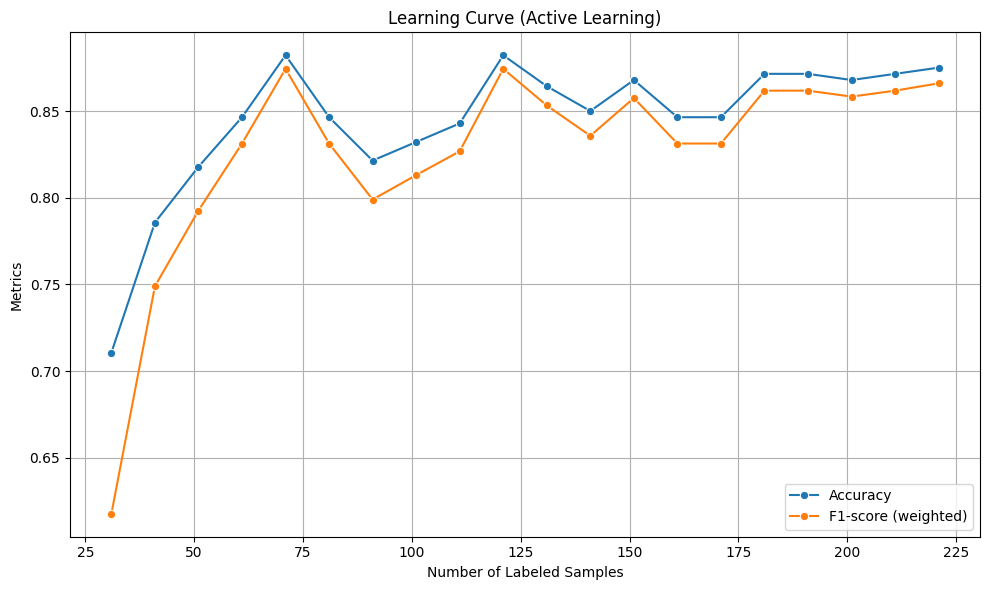

In [20]:
history_df = pd.DataFrame(history)

plt.figure(figsize=(10, 6))
sns.lineplot(data=history_df, x="n_samples", y="accuracy", marker="o", label="Accuracy")
sns.lineplot(data=history_df, x="n_samples", y="f1_score", marker="o", label="F1-score (weighted)")
plt.title("Learning Curve (Active Learning)")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Metrics")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()